Reliability Models for Facility Location:The Expected Failure Cost Case
---

Base on the following article:

*Snyder, L. V., & Daskin, M. S. (2005). Reliability models for facility location: the expected failure cost case. Transportation Science, 39(3), 400-416.*

In [16]:
# Colecting the problem
from netandloc.dataset.mongodb import MongoClient
# Solving the problem
from netandloc.solvers.uflp import uflp
# Representing the network
from netandloc.dataviz.network import Network

from sklearn.neighbors import DistanceMetric
from geopy.distance import great_circle

import scipy as sp
import numpy as np
import pandas as pd

%load_ext autoreload
%autoreload 2

ModuleNotFoundError: No module named 'netandloc'

In [17]:
!pip show NetAndLoc

Name: netandloc
Version: 1.0
Summary: Python Library To facilitate the manipulation of datasets from OR_NETWORK_AND_DISCRETE_LOCATION
Home-page: https://github.com/xNok/OR_NETWORK-AND-DISCRETE-LOCATION
Author: xNok
Author-email: nokwebspace@gmail.com
License: UNKNOWN
Location: /home/jovyan/work/OR_NETWORK-AND-DISCRETE-LOCATION/PythonLib
Requires: 
Required-by: 


## UFLP Solution to the 49-Node Dataset

First, we collect the dataset from our database using **MonClient**.

In [150]:
dataset = MongoClient(db = {
# MongoClient let us connect to the database and manipulate our dataset
    "mongo_host": "ns396089.ip-37-59-38.eu",
    "mongo_port": 32771,
    "mongo_db_name": "NETWORK-AND-DISCRETE-LOCATION"
}, q = {
    'metadata.author': 'Mark S. Daskin',
    'metadata.topic': 'NETWORK-AND-DISCRETE-LOCATION',
    'metadata.dataset': '49-nodes'
},f=None)

We can display the dataset using the method **get** which return a pandas Dataframe containing our data

In [151]:
df = dataset.get()
df.head()

,ID,LONGITUDE,LATITUDE,STATE POP,CITY POP,FIXED COST,CITY
0,1,-121.467360,38.566850,29760021,369365,115800,< Sacramento CA >
1,2,-73.799017,42.665750,17990455,101082,101800,< Albany NY >
2,11,-84.422592,33.762900,6478216,394017,71200,< Atlanta GA >
3,12,-77.474584,37.531050,6187358,203056,66600,< Richmond VA >
4,13,-71.017892,42.336029,6016425,574283,161400,< Boston MA >


The uncapacitated facility location problem takes as inputs two sets of **Customers** and **Facilities**, as well as the list **f** containing the fixed cost of each facility and the matrix **c** representing the cost of serving a customer given a facility.

In [152]:
# Set of customer
Customers = range(len(df.index))
Facilities = df.index
fixed_cost = df["FIXED COST"].values
# Distance matrix in Km frm long/lat
distances = DistanceMetric.get_metric('haversine').pairwise(df[["LATITUDE","LONGITUDE"]].apply(np.radians)) * 3959
# The transportation cost are taken to be $0.00001 per mile per unit of demande
# The demande is proportinal to the state population
transportation_cost = np.round(0.00001 * distances * df["STATE POP"][None, :].T)

# keep only significant values
fixed_cost = np.round(fixed_cost * 0.001)
transportation_cost = np.round(transportation_cost * 0.001)

The data for the 

In [153]:
m, X, Y = uflp(Customers, Facilities, fixed_cost, transportation_cost, name='UFLP')

In [171]:
from docplex.mp.environment import Environment
env = Environment()
env.print_information()
solution = m.solve()

* system is: Linux 64bit
* Python is present, version is 3.6.8
* docplex is present, version is (2, 4, 61)
* CPLEX wrapper is present, version is 12.8.0.0, located at: /opt/conda/lib/python3.6/site-packages


In [173]:
m.export_as_lp("uflp_formulation")
solution.export("uflp_solution.json")
solution.solve_details.time

0.004161834716796875

In [160]:
solution.kpi_value_by_name("transportation cost")

508.0

In [161]:
solution.kpi_value_by_name("fixed cost")

348.0

In [162]:
solution.get_objective_value()

856.0

## Analyse the probleme and the solution

We use the **dataviz** package to convert our dataset into a **Network** object so that we can plot it.

/opt/conda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


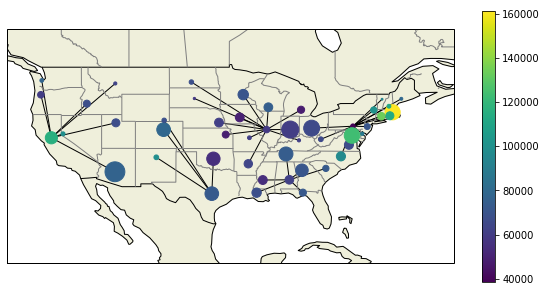

In [178]:
network = Network(dataset)
network.G.add_edges_from([key for key in X if X[key].solution_value == 1])
network.plot_nodes(node_size=("CITY POP",1/2500), node_color="FIXED COST")

In [179]:
facility_solution = df.iloc[[key for key in Y if Y[key].solution_value == 1]]
demand_served = pd.DataFrame([[df.iloc[j].name,df.iloc[i]["STATE POP"]] for i,j in X if X[i,j].solution_value == 1],columns=["","demande"]) \
                    .groupby("").sum() \
                    .apply(lambda x: 100 * x / float(x.sum())).round()

facility_solution.join(demand_served)

,ID,LONGITUDE,LATITUDE,STATE POP,CITY POP,FIXED COST,CITY,demande
0,1,-121.467360,38.566850,29760021,369365,115800,< Sacramento CA >,19.0
12,3,-97.750522,30.305880,16986510,465622,72600,< Austin TX >,10.0
14,22,-86.284287,32.354400,4040587,187106,62200,< Montgomery AL >,16.0
34,5,-76.884503,40.276050,11881643,52376,38400,< Harrisburg PA >,33.0
44,6,-89.644654,39.781433,11430602,105227,59200,< Springfield IL >,22.0
